In [1]:
#%matplotlib widget
from lib.initial_states import initialState
from lib.hamiltonian import H_B, H_D, H_P
from lib.time import S
from lib.schrodinger import yves_TDSE
from lib import X, D, yvesData
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from joblib import Memory
import itertools
import tqdm

memory = Memory(location=".joblib_cache", verbose=0)

N = 4
nsteps = 100
T_0 = 15
T_f = 1500
pen = 10
beta = -1

Hf = H_B(N) + pen * H_P(N)
Hi = beta*H_D(N, X)

psi_f = np.diag(Hf)

args = yvesData(Hf=Hf, Hi=Hi, t=T_0, n=N)

ts = np.linspace(T_0, T_f, nsteps)
f_all = False


def check_degrenecy(arr):
    min_value = np.min(arr)
    mask = (arr == min_value)
    return np.count_nonzero(mask)
c = check_degrenecy(psi_f)

if c > 1:
    print(f"Solution is degenerate, there are {c} occurences")
    idx = np.where(psi_f == np.min(psi_f))[0]
    print(f"They are located at indecies {idx}")

After we have imported all of our dependencies, we can go ahead and implement the Time-dependent Schrodinger equation which was proposed by Yves Rezus.



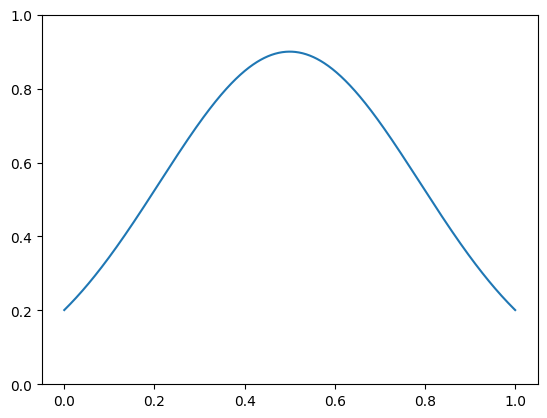

In [2]:
x = np.linspace(0, 1, 1000)
smax = 0.9
y = S(x)
# y = smax*np.exp(-6*(x-D/2)**2)
plt.ylim([0, 1])
plt.plot(x, y)
plt.show()

To first understand how the energies change in this new scheme we should look at how the hamiltonian changes as we tune $ \gamma $ from 0 -> 1. 

$$
 H = \gamma*H_f + (1 - \gamma)*H_i
$$

In [3]:
def hamiltonian_energies(N):
    energies = []
    gamma_vals = []
    vecs = []
    
    for t in ts:
        gamma = t/T_f
        H = gamma * Hf + (1 - gamma) * Hi
        eigvals, vec = np.linalg.eigh(H)
        energies.append(eigvals)
        vecs.append(vec)
        gamma_vals.append(gamma)

    return np.array(energies), np.array(vecs), gamma_vals

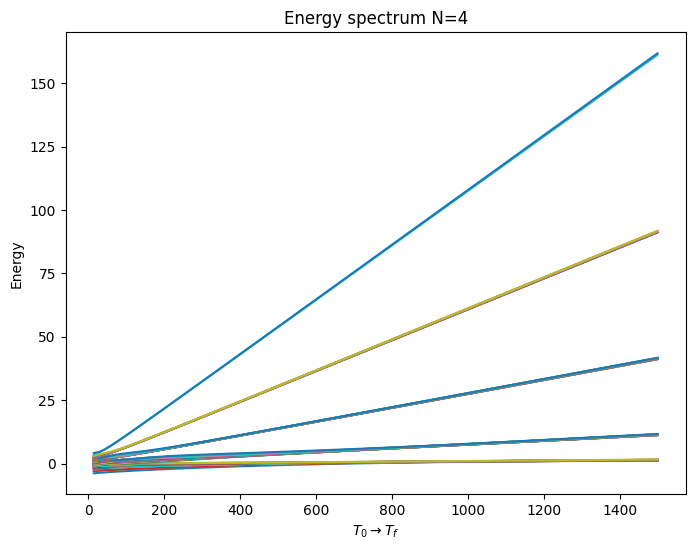

In [4]:
energies, vecs, gamma_vals = hamiltonian_energies(N)

plt.figure(figsize=(8, 6))
for i in range(energies.shape[1]):
    plt.plot(ts, energies[:, i])
plt.xlabel(r"$T_0 \to T_f$")
plt.ylabel("Energy")
plt.title(f"Energy spectrum {N=}")
plt.savefig("spectrum.pdf")
plt.show()

We can no see how the energy spectrum looks 

(1, -1, -1, 1)


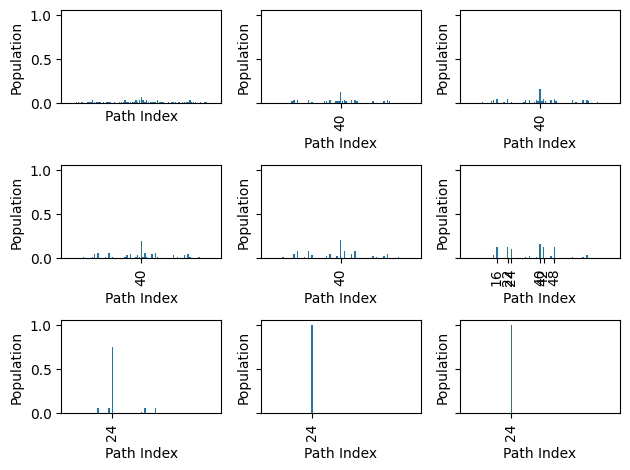

In [5]:
@memory.cache
def all_move_sequences(N):
    moves = (1, 0, -1)
    return list(itertools.product(moves, repeat=N))

vec = np.array([np.abs(v[:, 0])**2 for v in vecs])
fig, axes = plt.subplots(3, 3, sharey=True)
indices = np.arange(vecs.shape[1])
alpha_indices = np.linspace(0, len(vec)-1, 9, dtype=int)
selected_eigvecs = [vec[i] for i in alpha_indices]
moves = all_move_sequences(N)
for i, eigvec in enumerate(selected_eigvecs):
    ax = axes.flat[i]
    ax.bar(indices, eigvec, linewidth=1)
    ax_ids = []
    for j in range(len(eigvec)):
        if eigvec[j] > 1e-1:
            ax_ids.append(j)
    ax.set_xlabel("Path Index")
    ax.set_ylabel("Population")
    ax.set_xticks(ax_ids)
    ax.set_xticklabels(ax_ids, rotation=90)
last = selected_eigvecs[-1]
ind = np.argwhere(last > 1e-2)
for i in ind:
    print(moves[i[0]])

plt.tight_layout() 
plt.show()

In the plot above we can see which state we should end up in. 

This means that we only need to compute the following four matrix exponentials 
$$
\begin{eqnarray}
e^{A_0} & = & \exp\left[-i\gamma_0 H_f \frac{\Delta t^2}{4\hbar}\right]  \\
M_A & = & \exp\left[-i\gamma_0 H_f \frac{\Delta t^2}{2\hbar}\right]  \\
e^{B_0} & = & \exp \left[ -i H_i \frac{\Delta t}{\hbar} + 
i \gamma_0 H_i\frac{\Delta t^2}{2\hbar} \right]\\
M_B & = & \exp\left[i\gamma_0 H_i \frac{\Delta t^2}{\hbar}\right]
\end{eqnarray}
$$

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:53<00:00,  6.54s/it]


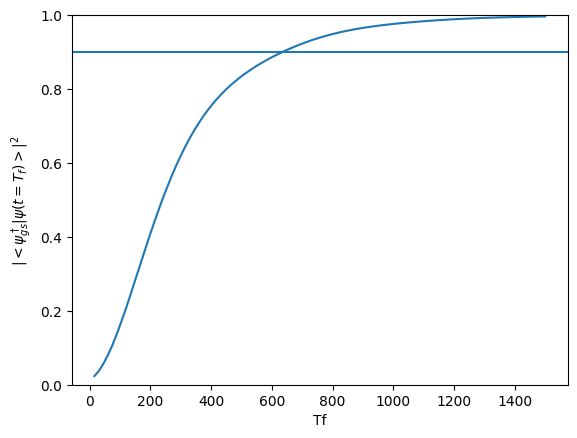

In [6]:
fidelities = []
gs_idx = np.argmin(psi_f)
plot_all = False

for t in tqdm.tqdm(ts):
    args.t = t
    psi = yves_TDSE(args)
    if plot_all:
        fidelities.append(np.abs(psi))
    else:
        fidelity = np.abs(psi[gs_idx])**2
        fidelities.append(fidelity)


plt.figure()
plt.ylim(0, 1)
plt.xlabel("Tf")
plt.ylabel(r"$ |<\psi^\dagger_{gs} | \psi(t=T_f)>|^2 $")
plt.plot(ts, fidelities)
plt.axhline(0.9)
plt.show()

In [7]:
"""
import csv
import pathlib
f_name = f"{nsteps}_{beta}_{T_0}_{T_f}_{pen}_fids.csv"

data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True, parents=True)

file_path = data_dir / f_name
file_path.touch(exist_ok=True)

fidelities = np.array(fidelities)

data = {N: fidelities.tolist()}

with open(file_path, newline="") as csvfile:
    data_reader = csv.reader(csvfile, delimiter=',')
    for d in data_reader:
        key = int(d[0])
        if key not in data:
            data[key] = d[1]

with open(file_path, "w", newline="") as f:
    writer = csv.writer(f)
    for k, v in data.items():
        writer.writerow([k, v])

"""


'\nimport csv\nimport pathlib\nf_name = f"{nsteps}_{beta}_{T_0}_{T_f}_{pen}_fids.csv"\n\ndata_dir = pathlib.Path("data")\ndata_dir.mkdir(exist_ok=True, parents=True)\n\nfile_path = data_dir / f_name\nfile_path.touch(exist_ok=True)\n\nfidelities = np.array(fidelities)\n\ndata = {N: fidelities.tolist()}\n\nwith open(file_path, newline="") as csvfile:\n    data_reader = csv.reader(csvfile, delimiter=\',\')\n    for d in data_reader:\n        key = int(d[0])\n        if key not in data:\n            data[key] = d[1]\n\nwith open(file_path, "w", newline="") as f:\n    writer = csv.writer(f)\n    for k, v in data.items():\n        writer.writerow([k, v])\n\n'